In [44]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import wrangle
from acquire import get_zillow_data
# Statistical Tests
import scipy.stats as stats

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#Modeling Imports
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans, dbscan


pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_columns', 80)

In [2]:
df=wrangle.tidy_wrangle()

In [45]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.data_split(df, stratify_by='logerror')

In [46]:
# scale the data
from sklearn.preprocessing import MinMaxScaler

# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(X_train)

# Use the scaler
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [75]:
X_train_scaled.shape

(38835, 13)

In [47]:
X = X_train_scaled

# Make the kmeans object
kmeans = KMeans(n_clusters=4)

# fit the kmeans model
kmeans.fit(X)

# use the thing
kmeans.predict(X)

array([3, 2, 3, ..., 1, 1, 1], dtype=int32)

In [33]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train_scaled[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

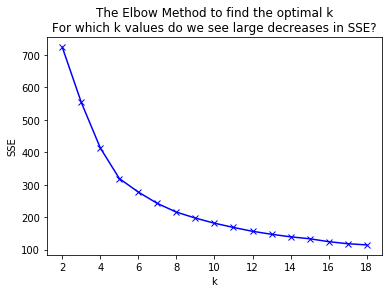

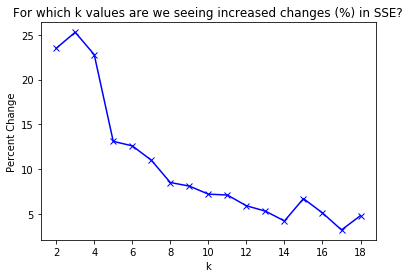

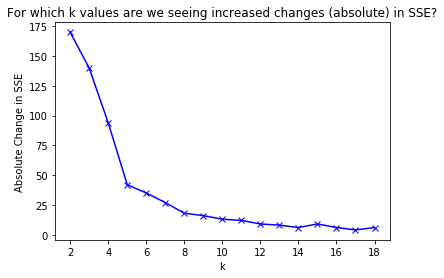

,k,sse,delta,pct_delta
0,2,723.30,170.00,23.50
1,3,553.10,140.00,25.30
2,4,412.92,94.00,22.80
3,5,318.79,42.00,13.10
4,6,277.05,35.00,12.60
5,7,242.06,27.00,11.00
6,8,215.37,18.00,8.50
7,9,197.08,16.00,8.10
8,10,181.19,13.00,7.20
9,11,168.21,12.00,7.10


In [34]:
find_k(X_train_scaled, cluster_vars, k_range)

In [69]:
X = X_train_scaled[['land_dollar_per_sqft', 'tax_value', 'age']]

# Make the kmeans object
kmeans = KMeans(n_clusters=5)

# fit the kmeans model
kmeans.fit(X)

# use the thing
kmeans.predict(X)

array([3, 3, 2, ..., 3, 2, 1], dtype=int32)

In [70]:
X_train_scaled['cluster'] = kmeans.predict(X)

In [71]:
pd.DataFrame(centroid_df.groupby(['area_cluster', 'centroid_land_dollar_per_sqft', 'centroid_tax_value', 
                           'centroid_age'])['area_cluster'].value_counts())

,,,,,area_cluster
area_cluster,centroid_land_dollar_per_sqft,centroid_tax_value,centroid_age,area_cluster,
0,55.31,"592,579.56",43.57,0,1
1,111.34,"1,320,975.50",41.83,1,1
2,18.55,"223,381.65",51.37,2,1
3,210.75,"2,868,664.40",39.98,3,1


In [72]:
kmeans.cluster_centers_

array([[0.03310041, 0.08473735, 0.64663989],
       [0.03146895, 0.12700428, 0.10840977],
       [0.01857367, 0.07102202, 0.26388688],
       [0.02162909, 0.06864753, 0.43687745],
       [0.12494778, 0.46608795, 0.28627717]])

In [73]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,land_dollar_per_sqft,tax_value,age
0,0.03,0.08,0.65
1,0.03,0.13,0.11
2,0.02,0.07,0.26
3,0.02,0.07,0.44
4,0.12,0.47,0.29


In [61]:
X_train_scaled.groupby('cluster')['land_dollar_per_sqft', 'tax_value', 'age'].mean()

,land_dollar_per_sqft,tax_value,age
cluster,,,
0,0.12,0.44,0.25
1,0.02,0.07,0.41
2,0.02,0.09,0.19
3,0.03,0.08,0.63


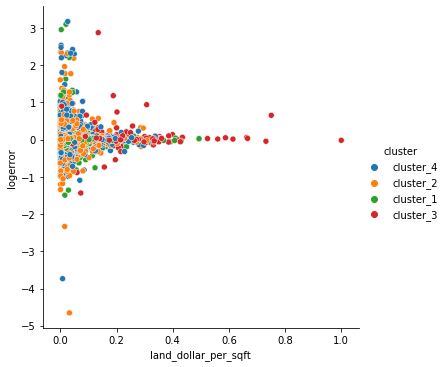

In [65]:
kmeans = KMeans(n_clusters=4).fit(X)
X_train_scaled['cluster'] = kmeans.predict(X)
X_train_scaled.cluster = 'cluster_' + (X_train_scaled.cluster + 1).astype('str')
sns.relplot(data=X_train_scaled, x='land_dollar_per_sqft', y=y_train.logerror, hue='cluster')






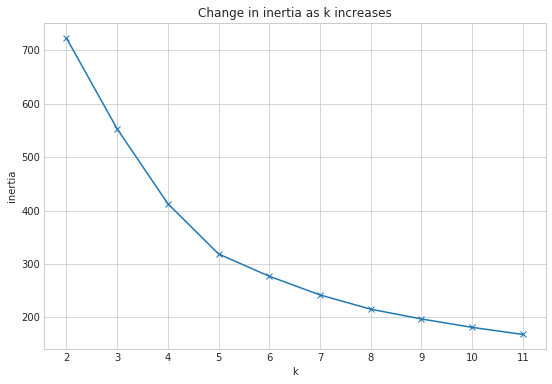

In [66]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

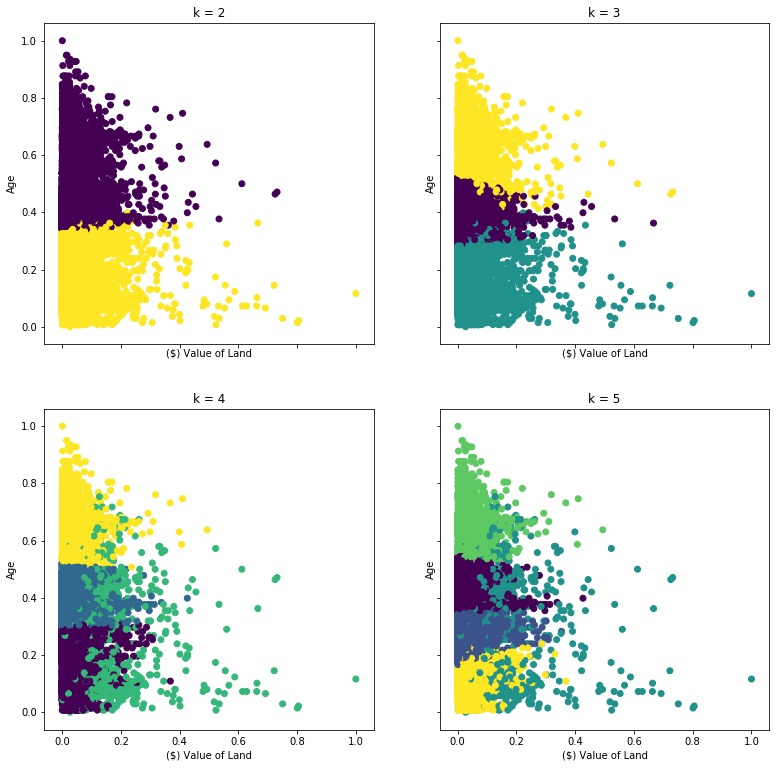

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(X).predict(X)
    ax.scatter(X.land_dollar_per_sqft, X.age, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='($) Value of Land', ylabel='Age')